<a href="https://colab.research.google.com/github/Snehalwadile/Time-Series-Model/blob/main/Time%20series-%20Decomposing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

MSFT Stock Forecast (2025–2034) using LSTM

Please upload MSFT_Historical_Data.csv


Saving MSFT_Historical_Data.csv to MSFT_Historical_Data (2).csv
Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



99/99 ━━━━━━━━━━━━━━━━━━━━ 12s 75ms/step - loss: 0.0078
Epoch 2/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 7s 66ms/step - loss: 1.3742e-04
Epoch 3/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 10s 66ms/step - loss: 1.2043e-04
Epoch 4/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 11s 70ms/step - loss: 1.2806e-04
Epoch 5/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 12s 84ms/step - loss: 1.1266e-04
Epoch 6/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 7s 67ms/step - loss: 1.7580e-04
Epoch 7/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 12s 80ms/step - loss: 1.3680e-04
Epoch 8/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 8s 81ms/step - loss: 1.1262e-04
Epoch 9/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 7s 73ms/step - loss: 1.1918e-04
Epoch 10/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 8s 79ms/step - loss: 1.0588e-04
Epoch 11/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 11s 85ms/step - loss: 8.2731e-05
Epoch 12/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 10s 82ms/step - loss: 7.7846e-05
Epoch 13/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - loss: 1.1547e-04
Epoch 14/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 10s 64ms/step - loss: 7.3827e-05
Epoch 15/20
99/99 ━━━━

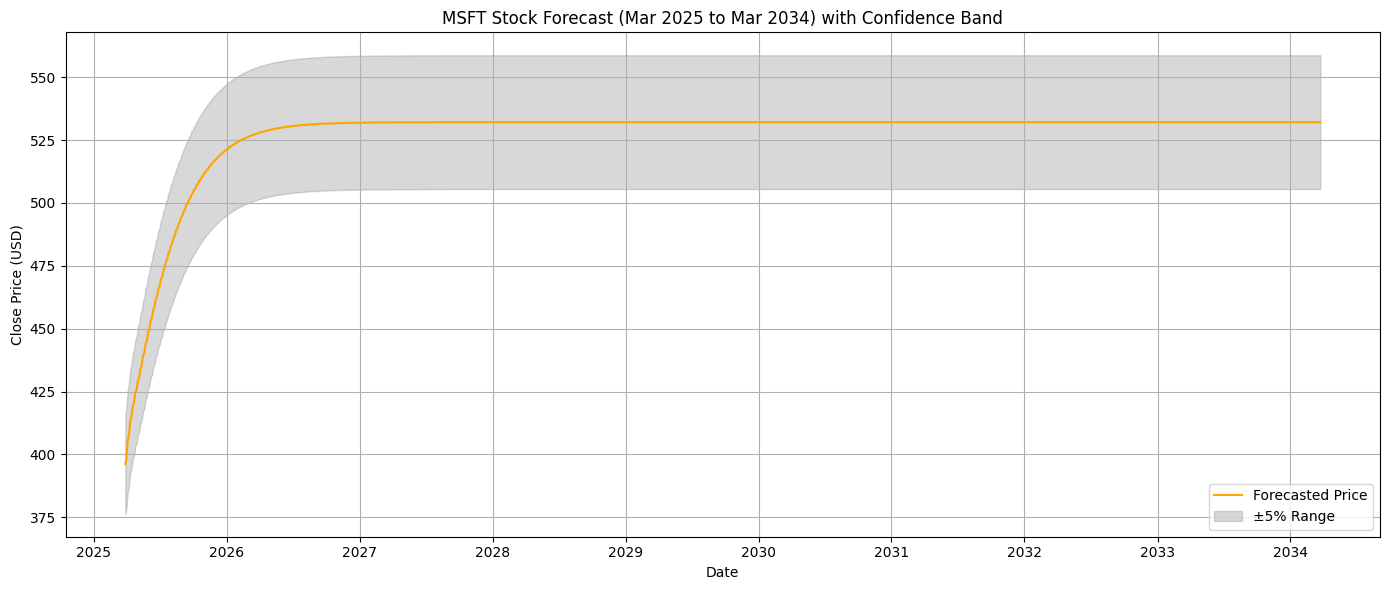


Last 10 Forecasted Values:


,Predicted_Price
Date,
2034-03-13,532.137695
2034-03-14,532.137634
2034-03-15,532.137634
2034-03-16,532.137634
2034-03-17,532.137634
2034-03-20,532.137634
2034-03-21,532.137634
2034-03-22,532.137634
2034-03-23,532.137634


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from datetime import datetime, timedelta
from google.colab import files
import plotly.graph_objects as go

# --- 1. Upload Historical Data ---
print("Please upload MSFT_Historical_Data.csv")
uploaded = files.upload()

# Read the uploaded CSV file
file_name = list(uploaded.keys())[0]
df = pd.read_csv(file_name, parse_dates=['Date'])
df = df[['Date', 'Close']].dropna()
df.set_index('Date', inplace=True)

# --- 2. Scale the 'Close' prices ---
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df[['Close']])

# --- 3. Create dataset (sliding window) ---
def create_dataset(data, time_step=60):
    X, y = [], []
    for i in range(time_step, len(data)):
        X.append(data[i - time_step:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

time_step = 60
X, y = create_dataset(scaled_data, time_step)
X = X.reshape((X.shape[0], X.shape[1], 1))

# --- 4. Build and train LSTM model ---
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(time_step, 1)),
    LSTM(50, return_sequences=False),
    Dense(25),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X, y, epochs=20, batch_size=64, verbose=1)

# --- 5. Predict from tomorrow to 26-Mar-2034 ---
forecast_start_date = datetime.today() + timedelta(days=1)
forecast_end_date = datetime(2034, 3, 26)

# Approximate number of business days (weekends excluded)
future_days = np.busday_count(forecast_start_date.date(), forecast_end_date.date())

# Use last 60 days from original dataset as seed input
last_sequence = scaled_data[-time_step:]

predicted_scaled = []

for _ in range(future_days):
    input_seq = last_sequence.reshape(1, time_step, 1)
    next_pred = model.predict(input_seq, verbose=0)[0][0]
    predicted_scaled.append(next_pred)
    last_sequence = np.append(last_sequence[1:], [[next_pred]], axis=0)

# Inverse transform predictions
predicted_prices = scaler.inverse_transform(np.array(predicted_scaled).reshape(-1, 1))

# --- 6. Generate future dates (weekdays only) ---
future_dates = pd.bdate_range(start=forecast_start_date, periods=future_days)
future_df = pd.DataFrame({'Date': future_dates, 'Predicted_Price': predicted_prices.flatten()})
future_df.set_index('Date', inplace=True)

# --- 7. Plot forecast only with confidence band ---
upper = future_df['Predicted_Price'] * 1.05
lower = future_df['Predicted_Price'] * 0.95

plt.figure(figsize=(14, 6))
plt.plot(future_df['Predicted_Price'], label='Forecasted Price', color='orange')
plt.fill_between(future_df.index, lower, upper, color='gray', alpha=0.3, label='±5% Range')
plt.title("MSFT Stock Forecast (Mar 2025 to Mar 2034) with Confidence Band")
plt.xlabel("Date")
plt.ylabel("Close Price (USD)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- 8. Interactive Plot with Plotly ---
fig = go.Figure()
fig.add_trace(go.Scatter(x=future_df.index, y=future_df['Predicted_Price'], mode='lines', name='Forecast'))
fig.update_layout(title='MSFT Forecast (2025–2034) – Interactive',
                  xaxis_title='Date',
                  yaxis_title='Predicted Price (USD)',
                  template='plotly_white')
fig.show()

# --- 9. Display last 10 forecasted values ---
print("\nLast 10 Forecasted Values:")
display(future_df.tail(10))

# --- 10. Save to CSV and allow download ---
future_df.to_csv("MSFT_Prediction_2025_to_2034.csv")
files.download("MSFT_Prediction_2025_to_2034.csv")

Decomposing the above timeseries into 4 components

Please upload MSFT_Historical_Data.csv


Saving MSFT_Historical_Data.csv to MSFT_Historical_Data (3).csv


<ipython-input-10-ac093de34ab0>:17: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.



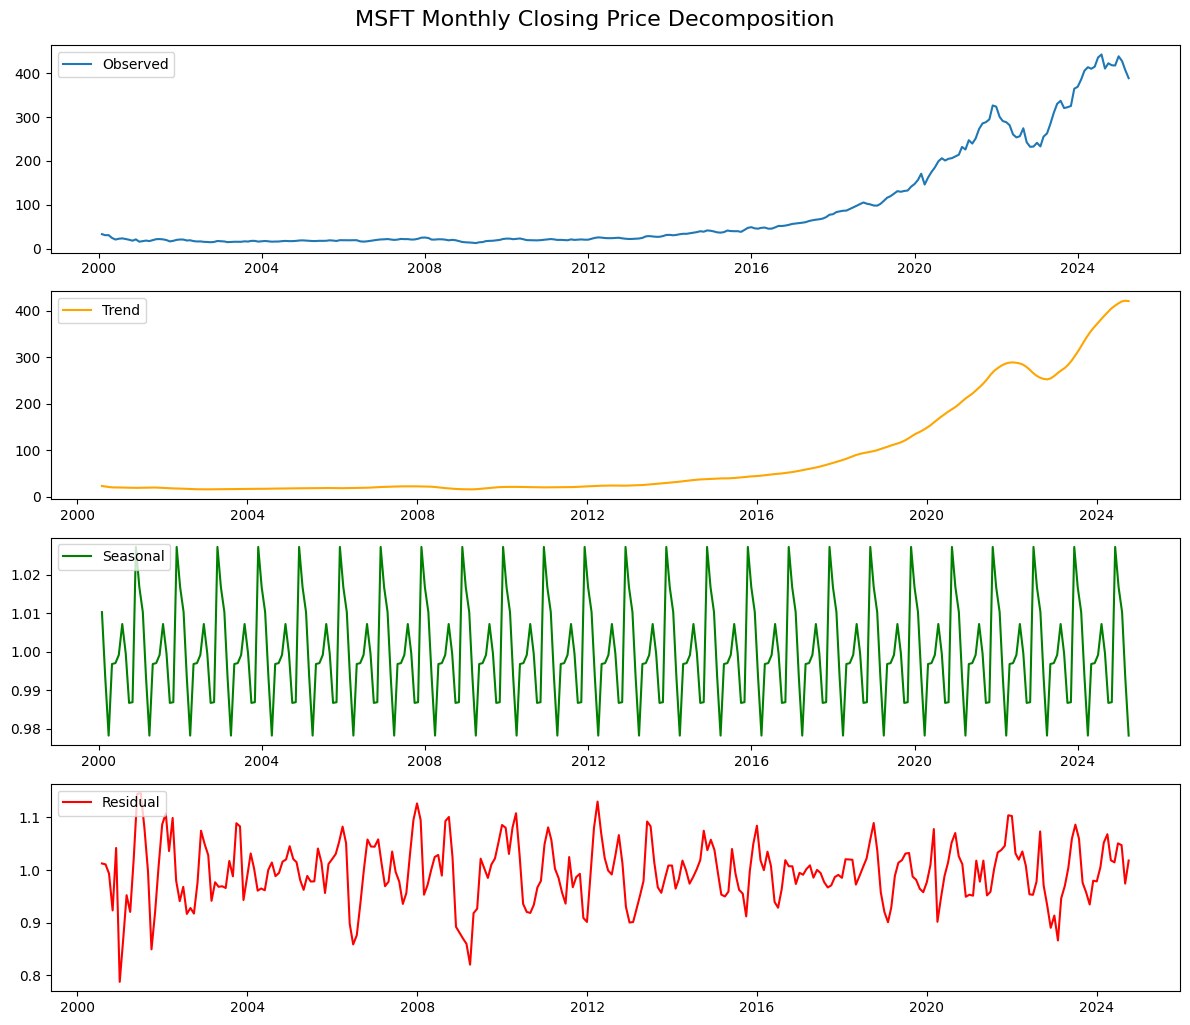

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from google.colab import files

# 1. Upload the file
print("Please upload MSFT_Historical_Data.csv")
uploaded = files.upload()

# 2. Load CSV
file_name = list(uploaded.keys())[0]
df = pd.read_csv(file_name, parse_dates=['Date'])
df = df[['Date', 'Close']].dropna()
df.set_index('Date', inplace=True)

# 3. Resample daily data to monthly average to highlight trend/seasonality
monthly_df = df['Close'].resample('M').mean()

# 4. Decompose the time series
decomposition = seasonal_decompose(monthly_df, model='multiplicative', period=12)

# 5. Plot the components
plt.figure(figsize=(12, 10))
plt.subplot(411)
plt.plot(decomposition.observed, label='Observed')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(decomposition.trend, label='Trend', color='orange')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(decomposition.seasonal, label='Seasonal', color='green')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(decomposition.resid, label='Residual', color='red')
plt.legend(loc='upper left')
plt.tight_layout()
plt.suptitle("MSFT Monthly Closing Price Decomposition", fontsize=16, y=1.02)
plt.show()
